# Example `Dysmalpy` Outflow Model Fit

**Includes the following components:**

 - Biconical Outflow

In this example, we use `dysmalpy` to fit a biconical outflow model to galaxy **NGC5728** using $\texttt{MPFIT}$ as well as $\texttt{MCMC}$.  

 - **The structure of the notebook is the following:**
 
 1) Setup steps
 2) Initialize galaxy, model set, instrument
 3) MPFIT fitting
 4) MCMC fitting

## 1) Setup steps ##

**Import modules**

In [84]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import dysmalpy
from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes
from dysmalpy import observation
from dysmalpy import config
from dysmalpy import fitting_wrappers

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

In [85]:
# A check for compatibility:
import emcee
if int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle' 

**Setup notebook**

In [86]:
# Setup plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

from IPython.core.display import Image

In [87]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

**Set data, output paths**

In [88]:
# Data directory
dir_path = os.path.abspath(fitting.__path__[0])
data_dir = os.sep.join([os.sep.join(dir_path.split(os.sep)[:-1]),'tests', 'test_data', ''])
#'/YOUR/DATA/PATH/'
print(data_dir)

# Where to save output files
#outdir = '/Users/ttshimiz/Dropbox/Research/DYSMALPY/dev/JUPYTER_OUTPUT_outflow/'
outdir = '/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_outflow/'

/Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/


-------------------

## 2) Initialize galaxy, model set, instrument

In [89]:
gal = galaxy.Galaxy(z=0.009353, name='NGC5728')
mod_set = models.ModelSet()

### Biconical Outflow Model

In [90]:
inner_angle = 25.           # Inner opening angle in degrees
dtheta = 5.                 # Outer opening angle in degrees
index = 1.0                 # Power-law index that controls the radial dependence of
                            # the outflow velocity
vmax = 700.                 # Maximum velocity in km/s
rend = 0.4                  # The radial extent of the outflow in kpc
profile_type = 'both'       # The velocity radial profile type.
                            # Can be 'increase', 'decrease', or 'both'.
rturn = 0.2                 # The turnover radius in kpc for the 'both' profile
norm_flux = 1.0           # Normalization for the flux profile which follows
                            # an exponential
tau = 5.0                   # How fast the flux falls off with radius

outflow_fixed = {'thetain': False,
                 'dtheta': True,
                 'n': True,
                 'vmax': False,
                 'rturn': False,
                 'rend': False,
                 'norm_flux':True}

outflow_bounds = {'thetain': (0, 50),
                 'dtheta': (0, 90),
                 'n': (0, 5),
                 'vmax': (500, 1000),
                 'rturn': (0.01, 1.0),
                 'rend': (0.01, 1.0)}

outflow = models.BiconicalOutflow(thetain=inner_angle, dtheta=dtheta,
                                  n=index, vmax=vmax, rend=rend,
                                  profile_type=profile_type, rturn=rturn,
                                  norm_flux=norm_flux, tau_flux=tau,
                                  fixed=outflow_fixed, bounds=outflow_bounds,
                                  name='outflow')
# Add the tied function for rturn
outflow.rturn.tied = fitting_wrappers.tied_functions.tie_rturn

### Geometry

In [91]:
out_pa = 45.              # Position angle in degrees with 0 corresponding to West
out_inc = 45.             # Inclination with 0 corresponding to face-on
out_xshift = 9.5          # X pixel position of outflow center
out_yshift = 2.5          # Y pixel position of outflow center

out_geom_fixed = {'inc': False,
                  'pa': False,
                  'xshift': True,
                  'yshift': True}

out_geom_bounds = {'inc': (25, 90),
                   'pa': (20, 60),
                   'xshift': (-10, 10),
                   'yshift': (-10, 10)}

outflow_geom = models.Geometry(inc=out_inc, pa=out_pa,
                               xshift=out_xshift, yshift=out_yshift,
                               fixed=out_geom_fixed, bounds=out_geom_bounds,
                               name='outflow_geom', obs_name='sivi_2D')

### Dispersion

In [92]:
# Outflow dispersion
out_sigma0 = 80.     # Intrinsic dispersion at each radius in km/s
out_disp_fixed = {'sigma0': True}
out_disp_bounds = {'sigma0': (0, 1000)}

out_disp_prof = models.DispersionConst(sigma0=out_sigma0, fixed=out_disp_fixed,
                                       bounds=out_disp_bounds, name='out_dispprof', tracer='sivi')

### Add all model components to ModelSet

In [93]:
# Add all of the model components to the ModelSet
mod_set.add_component(outflow, light=True)
mod_set.add_component(outflow_geom, geom_type='outflow')
mod_set.add_component(out_disp_prof, disp_type='outflow')

### Set kinematic options for calculating velocity profile

In [94]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = False

### Set up the observation and instrument

In [95]:
obs = observation.Observation(name='sivi_2D', tracer='sivi')
inst = instrument.Instrument()

beamsize = 0.15*u.arcsec                 # FWHM of beam
sig_inst = 60*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.05*u.arcsec           # arcsec/pixel
inst.fov = [82, 88]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

# Extraction information
inst.ndim = 2                            # Dimensionality of data
inst.moment = False                      # For 1D/2D data, if True then velocities and dispersion calculated from moments
                                         # Default is False, meaning Gaussian extraction used
    
# Add instrument to observation
obs.instrument = inst

### Load data

* Load the data from file:
  - *2D velocity, dispersion maps and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data2D` class

* Add data to Galaxy object

In [96]:
# FITS file structure:
#   Extension 0: Integrated flux
#   Extension 1: Velocity
#   Extension 2: Dispersion
#   Extension 3: Flux error
#   Extension 4: Velocity error
#   Extension 5: Dispersion error

hdu = fits.open(data_dir+'NGC5728_SiVI_line_map.fits')
flux = hdu[0].data
vel = hdu[1].data - 2773.0      # Subtract off systemic velocity
disp = hdu[2].data
flux_err = hdu[3].data
vel_err = hdu[4].data
disp_err = hdu[5].data

# Create a mask based on flux SNR, velocity error, and dispersion error
mask = ((np.isfinite(flux)) & (flux > 0) & (flux/flux_err >= 3.0) & (vel_err <= 50) & (disp_err <= 50) &
        (vel_err != 0) & (disp_err != 0) & (np.isfinite(disp_err)))

# Set minimum velocity error to 10 km/s
vel_err[vel_err < 10.] = 10.

inst_corr = False                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data2D data class: 
#    ** specifies data pixscale as well **
data2d = data_classes.Data2D(pixscale=inst.pixscale.value, velocity=vel,
                                  vel_disp=disp, vel_err=vel_err,
                                  vel_disp_err=disp_err, mask=mask,
                                  inst_corr=False)

# Use moment for extraction for example: 
#     Not how data was extracted, but it's a speedup for this example. 
#     
#     The best practic option, if the 2D maps are extracted with gaussians, 
#     is to compile the C++ extensions and pass the option 'gauss_extract_with_c=True'
#     when running fitting.fit_mpfit()
data2d.moment = True

# Add data to Observation:
obs.data = copy.deepcopy(data2d)

### Define model, fit options:

In [97]:
obs.mod_options.oversample = 1  
# Factor by which to oversample model (eg, subpixels)
# For increased precision, oversample=3 is suggested. 

obs.fit_options.fit = True             # Include this observation in the fit (T/F)
obs.fit_options.fit_velocity = True    # 1D/2D: Fit velocity of observation (T/F)
obs.fit_options.fit_dispersion = True  # 1D/2D: Fit dispersion of observation (T/F)
obs.fit_options.fit_flux = False       # 1D/2D: Fit flux of observation (T/F)

### Add the model set, observation to the Galaxy

In [98]:
gal.model = mod_set
gal.add_observation(obs)

-----------------

## 3) MPFIT Fitting

**Set up ``MPFITFitter`` fitter with fitting parameters**

In [99]:
# Options passed to MPFIT:
maxiter = 200

fitter = fitting.MPFITFitter(maxiter=maxiter)

**Set up fit/plot output options**

In [100]:
# Output directory
outdir_mpfit = outdir+'MPFIT/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mpfit, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MPFIT**

In [101]:
mpfit_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: NGC5728 using MPFIT
INFO:DysmalPy:    obs: sivi_2D
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2023-12-07 14:39:24.544509

INFO:DysmalPy:Iter 1  CHI-SQUARE = 242921.1872  DOF = 2341
   outflow:vmax = 700  
   outflow:thetain = 25  
   outflow:rend = 0.4  
   outflow_geom:inc = 45  
   outflow_geom:pa = 45  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 242904.2445  DOF = 2341
   outflow:vmax = 699.9999878  
   outflow:thetain = 25  
   outflow:rend = 0.3999999875  
   outflow_geom:inc = 44.99994944  
   outflow_geom:pa = 45.00000083  

INFO:DysmalPy:
End: 2023-12-07 14:39:54.387127

******************
Time= 29.84 (sec),   0:29.84 (m:s)
MPFIT Status = 2
MPFIT Error/Warning Message = None
******************


### Examine MPFIT results

#### Result plots

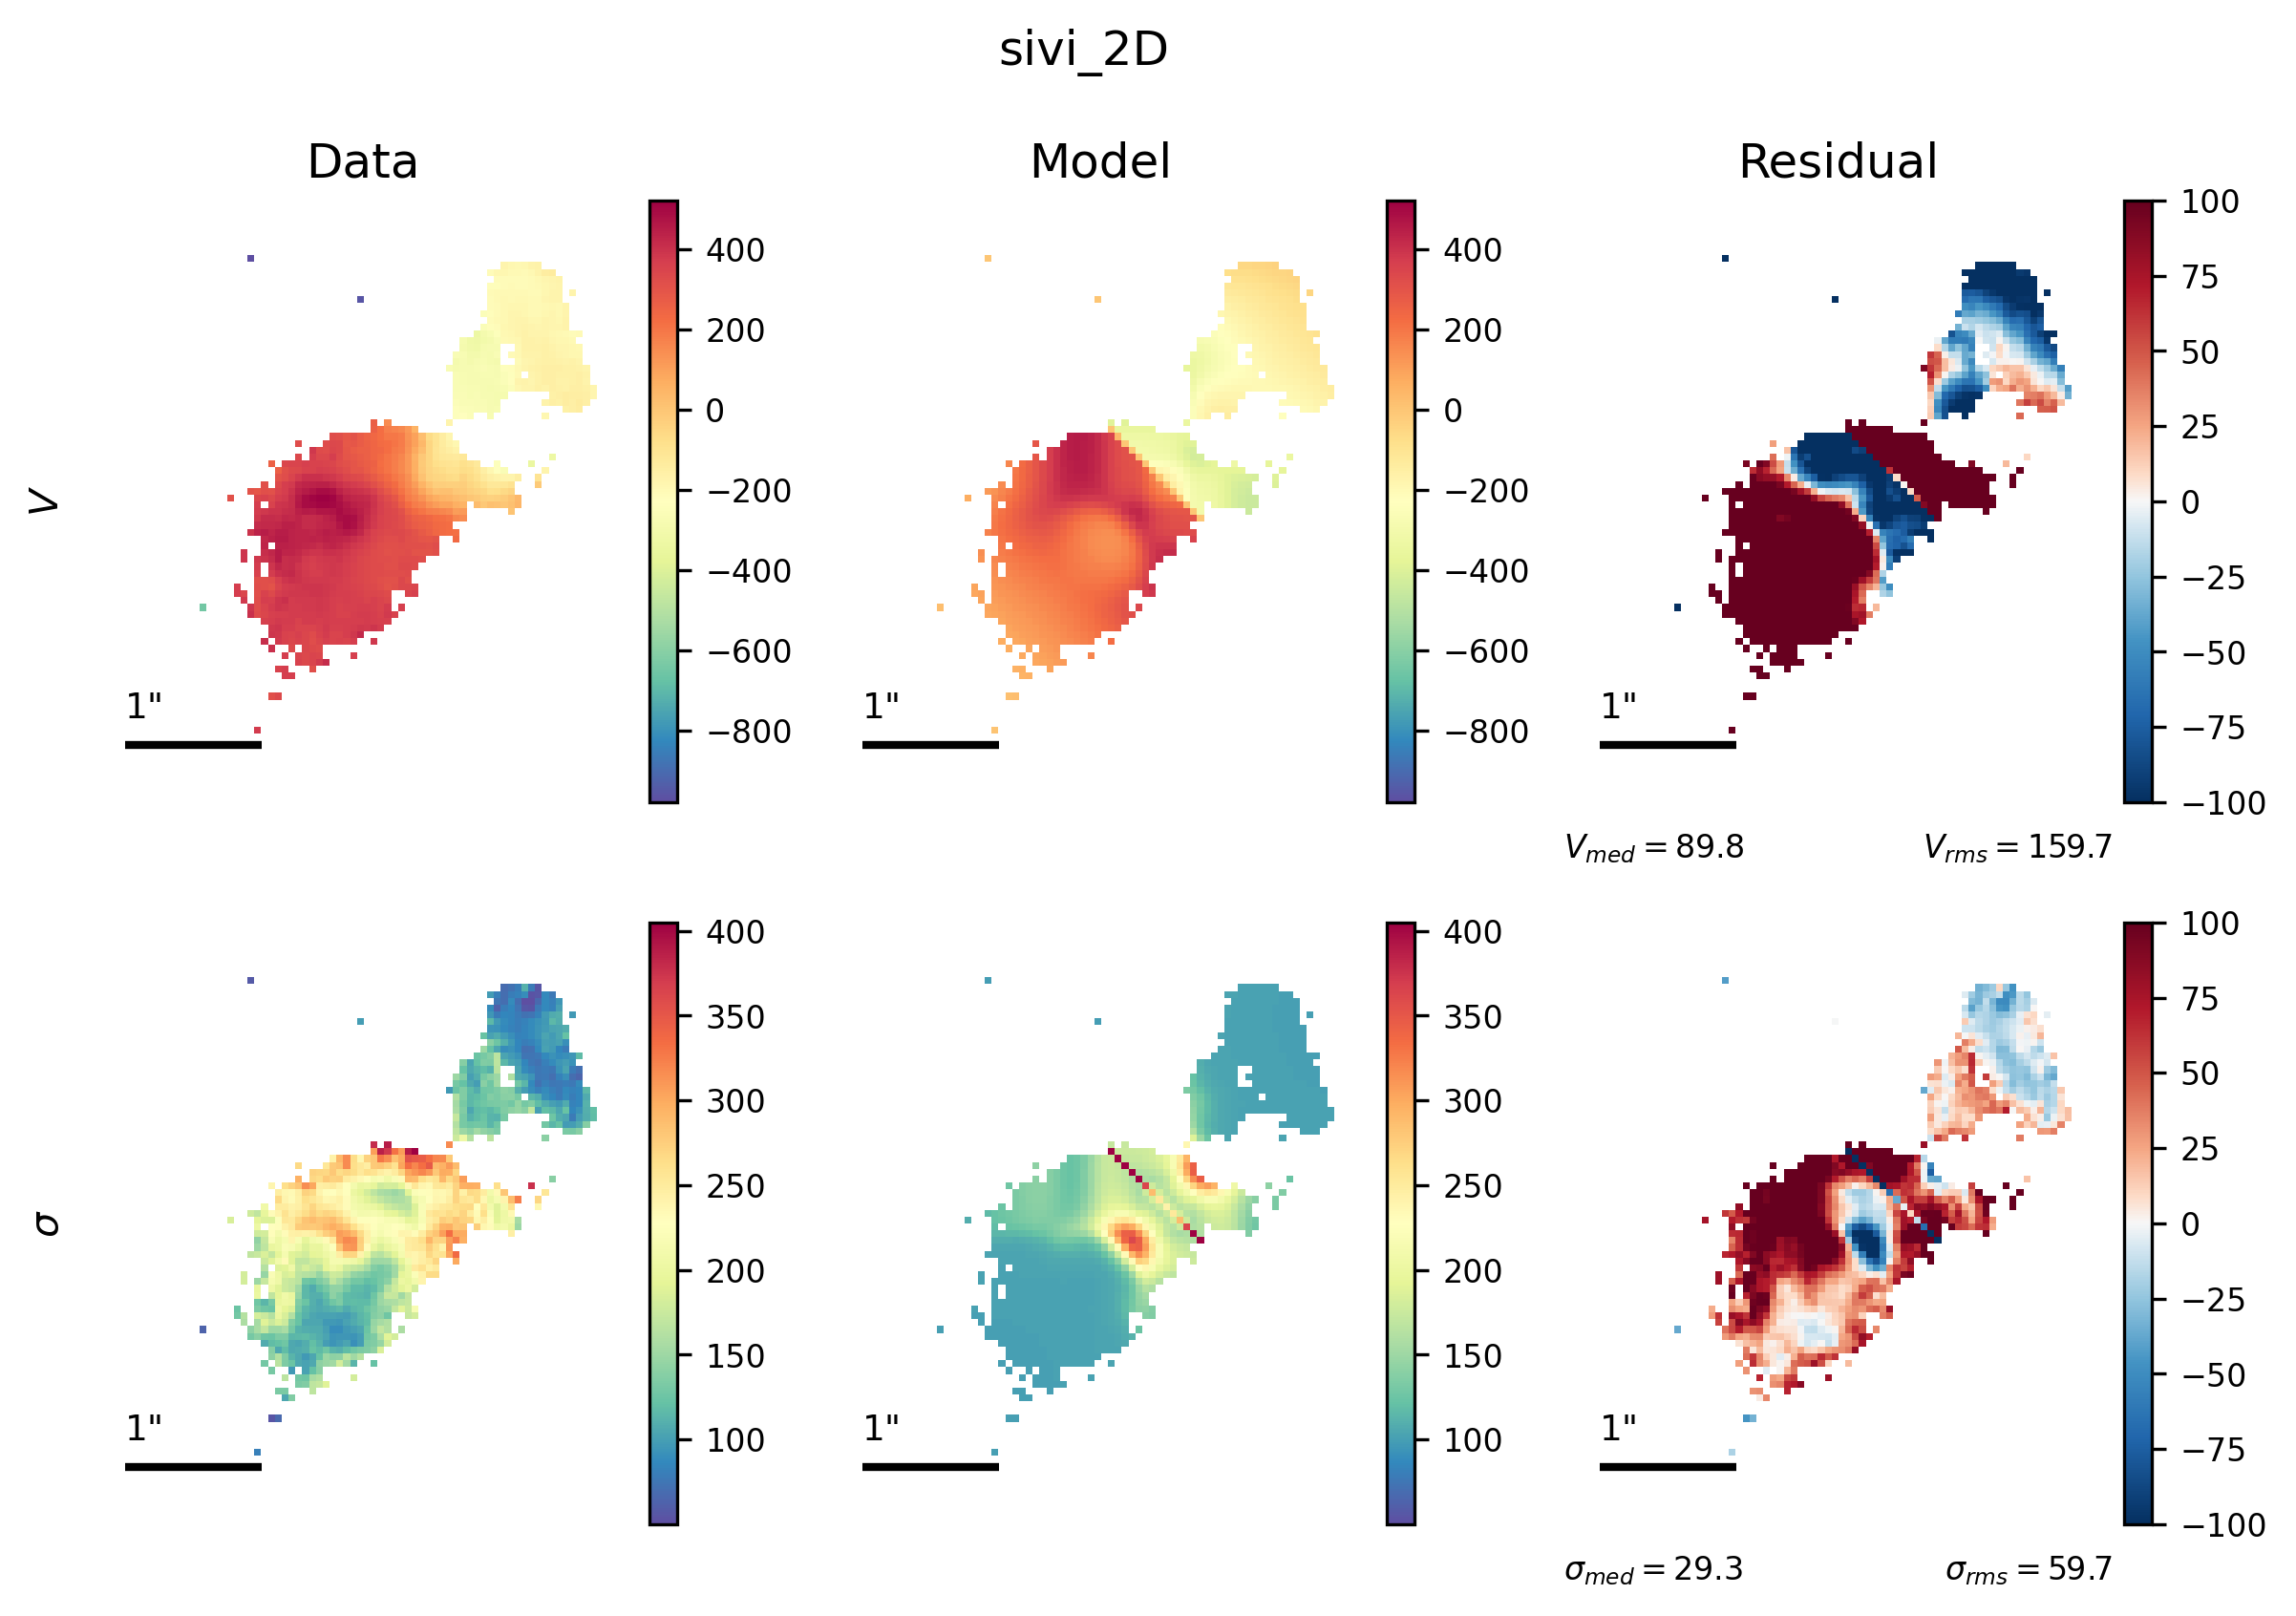

In [102]:
# Look at best-fit:
filepath = outdir_mpfit+"NGC5728_mpfit_bestfit_sivi_2D.{}".format(plot_type)
Image(filename=filepath, width=600)

#### Directly generating result plots ####

**Reload the galaxy, results files:**

In [103]:
f_galmodel =       outdir_mpfit + 'NGC5728_model.pickle'
f_mpfit_results =  outdir_mpfit + 'NGC5728_mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results, fit_method='mpfit')

**Plot the best-fit results:**

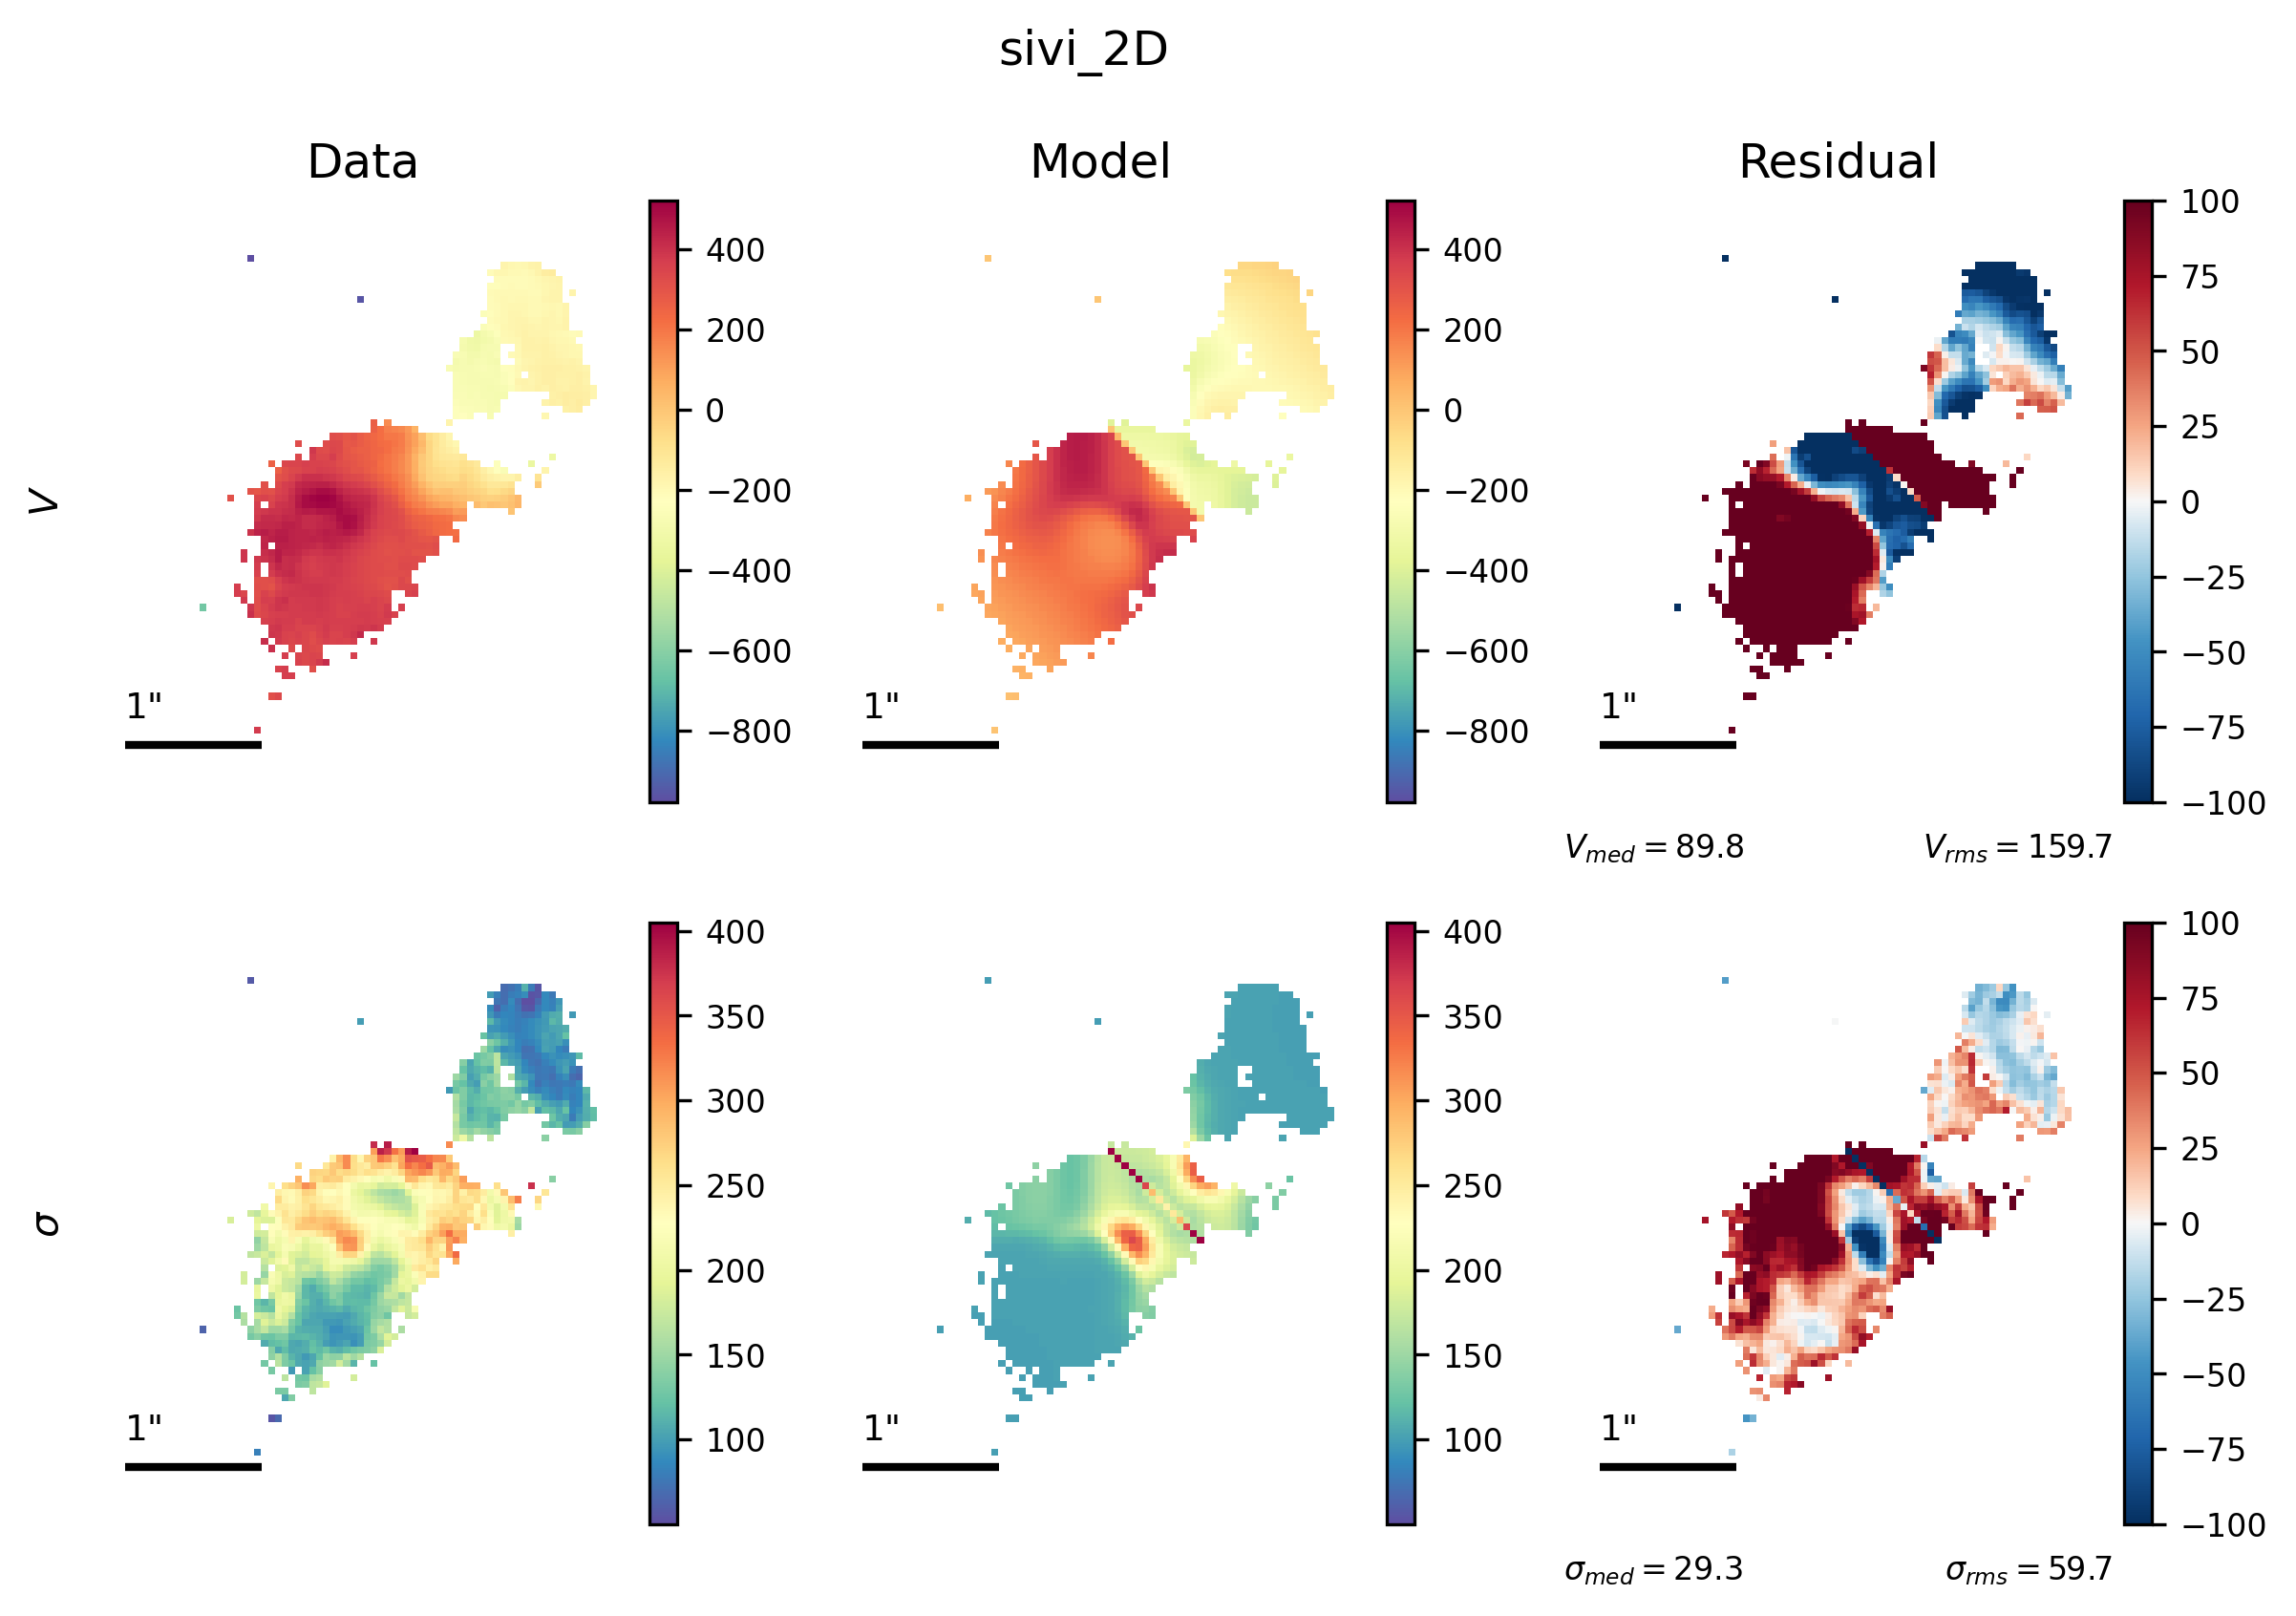

In [104]:
mpfit_results.plot_results(gal)

#### Result reports

We now look at the results reports, which include the best-fit values and uncertainties (as well as other fitting settings and output).

In [105]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for NGC5728

Date: 2023-12-07 14:39:59.613578

    obs: sivi_2D
         Datafiles:
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MPFIT
    fit status: 2

pressure_support:      False

###############################
 Fitting results
-----------
 outflow
    vmax              700.0000  +/-   0.0006
    thetain            25.0000  +/-   0.0000
    rend                0.4000  +/-   0.0000

    n                   1.0000  [FIXED]
    rturn               0.2000  [TIED]
    dtheta              5.0000  [FIXED]
    norm_flux           1.0000  [FIXED]
    tau_flux            5.0000  [FIXED]
-----------
 outflow_geom
    inc                44.9999  +/-   0.0001
    pa                 45.0000  +/-   0.0001

    xshift              9.5000

**To <span style="color:DarkCyan">directly save</span> the results report** to a file, we can use the following:

(Note: by default, report files are saved as part of the fitting process)

In [106]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## 4) MCMC Fitting

**Get a clean copy of model, obs**

In [107]:
gal = galaxy.Galaxy(z=0.009353, name='NGC5728')

obscopy = observation.Observation(name='sivi_2D', tracer='sivi')
obscopy.data = copy.deepcopy(data2d)
obscopy.instrument = copy.deepcopy(inst)
obscopy.mod_options = copy.deepcopy(obs.mod_options)
obscopy.fit_options = copy.deepcopy(obs.fit_options)

gal.add_observation(obscopy)

gal.model = copy.deepcopy(mod_set)

**Set up ``MCMCFitter`` fitter with fitting parameters**

In [108]:
# Options passed to emcee
## SHORT TEST:
nWalkers = 20
nCPUs = 4
scale_param_a = 5 #3   
# The walkers were not exploring the parameter space well with scale_param_a = 3, 
#     but were getting 'stuck'. So to improve the walker movement with larger 
#     'stretch' in the steps, we increased scale_param_a.
nBurn = 2
nSteps = 5
minAF = None
maxAF = None
nEff = 10

fitter = fitting.MCMCFitter(nWalkers=nWalkers, nCPUs=nCPUs, 
                            scale_param_a=scale_param_a, nBurn=nBurn, nSteps=nSteps, 
                            minAF=minAF, maxAF=maxAF, nEff=nEff)

**Set up fit/plot output options**

In [109]:
# Output directory
outdir_mcmc = outdir + 'MCMC/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mcmc, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MCMC**

In [110]:
mcmc_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: NGC5728 with MCMC
INFO:DysmalPy:    obs: sivi_2D
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 20
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: None
INFO:DysmalPy:
Burn-in:
Start: 2023-12-07 14:39:59.688786

INFO:DysmalPy: k=0, time.time=2023-12-07 14:39:59.690310, a_frac=nan
INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:numexpr.utils:N

### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

**Trace**
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

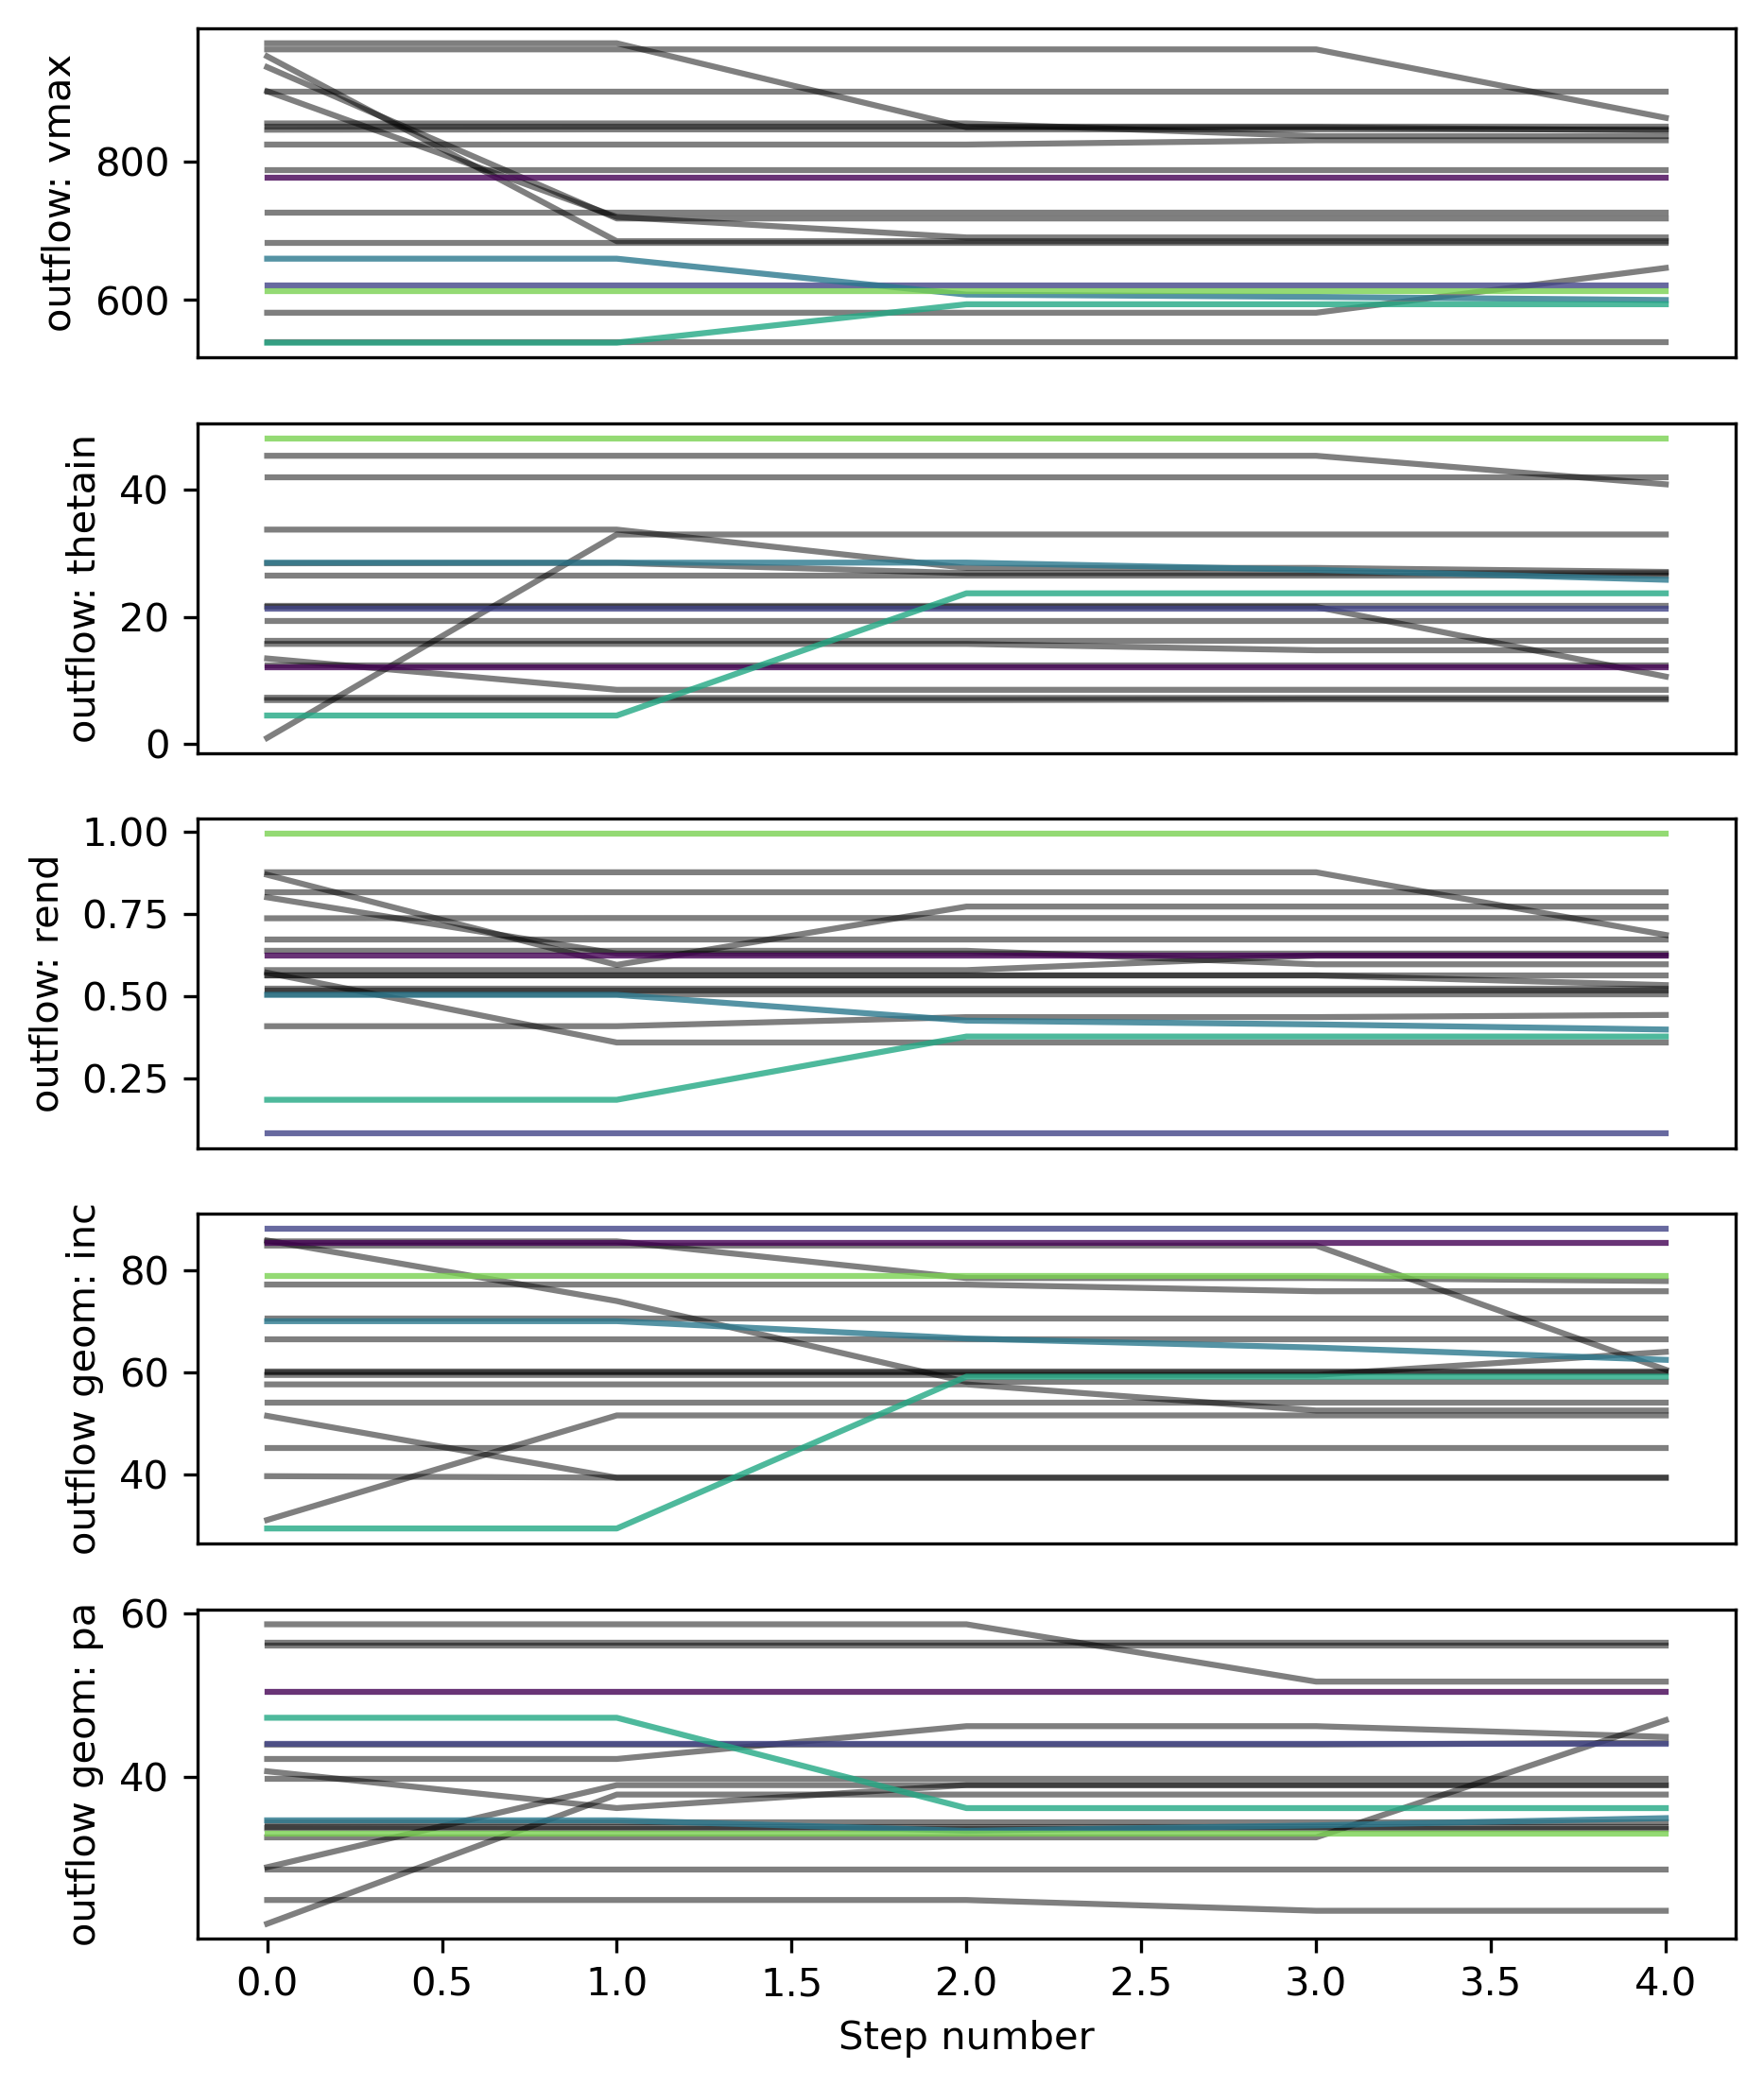

In [111]:
# Look at trace:
filepath = outdir_mcmc+"NGC5728_mcmc_trace.{}".format(plot_type)
Image(filepath, width=600)

**Best-fit**
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!
- Also, it's helpful to check that your data masking is reasonable.
- Finally, this is a worthwhile chance to see if your "nuisance" geometry and spectral parameters (especially `xshift`, `yshift`, `vel_shift` have reasonable values, and if appropriate, reasonable bounds and priors.)

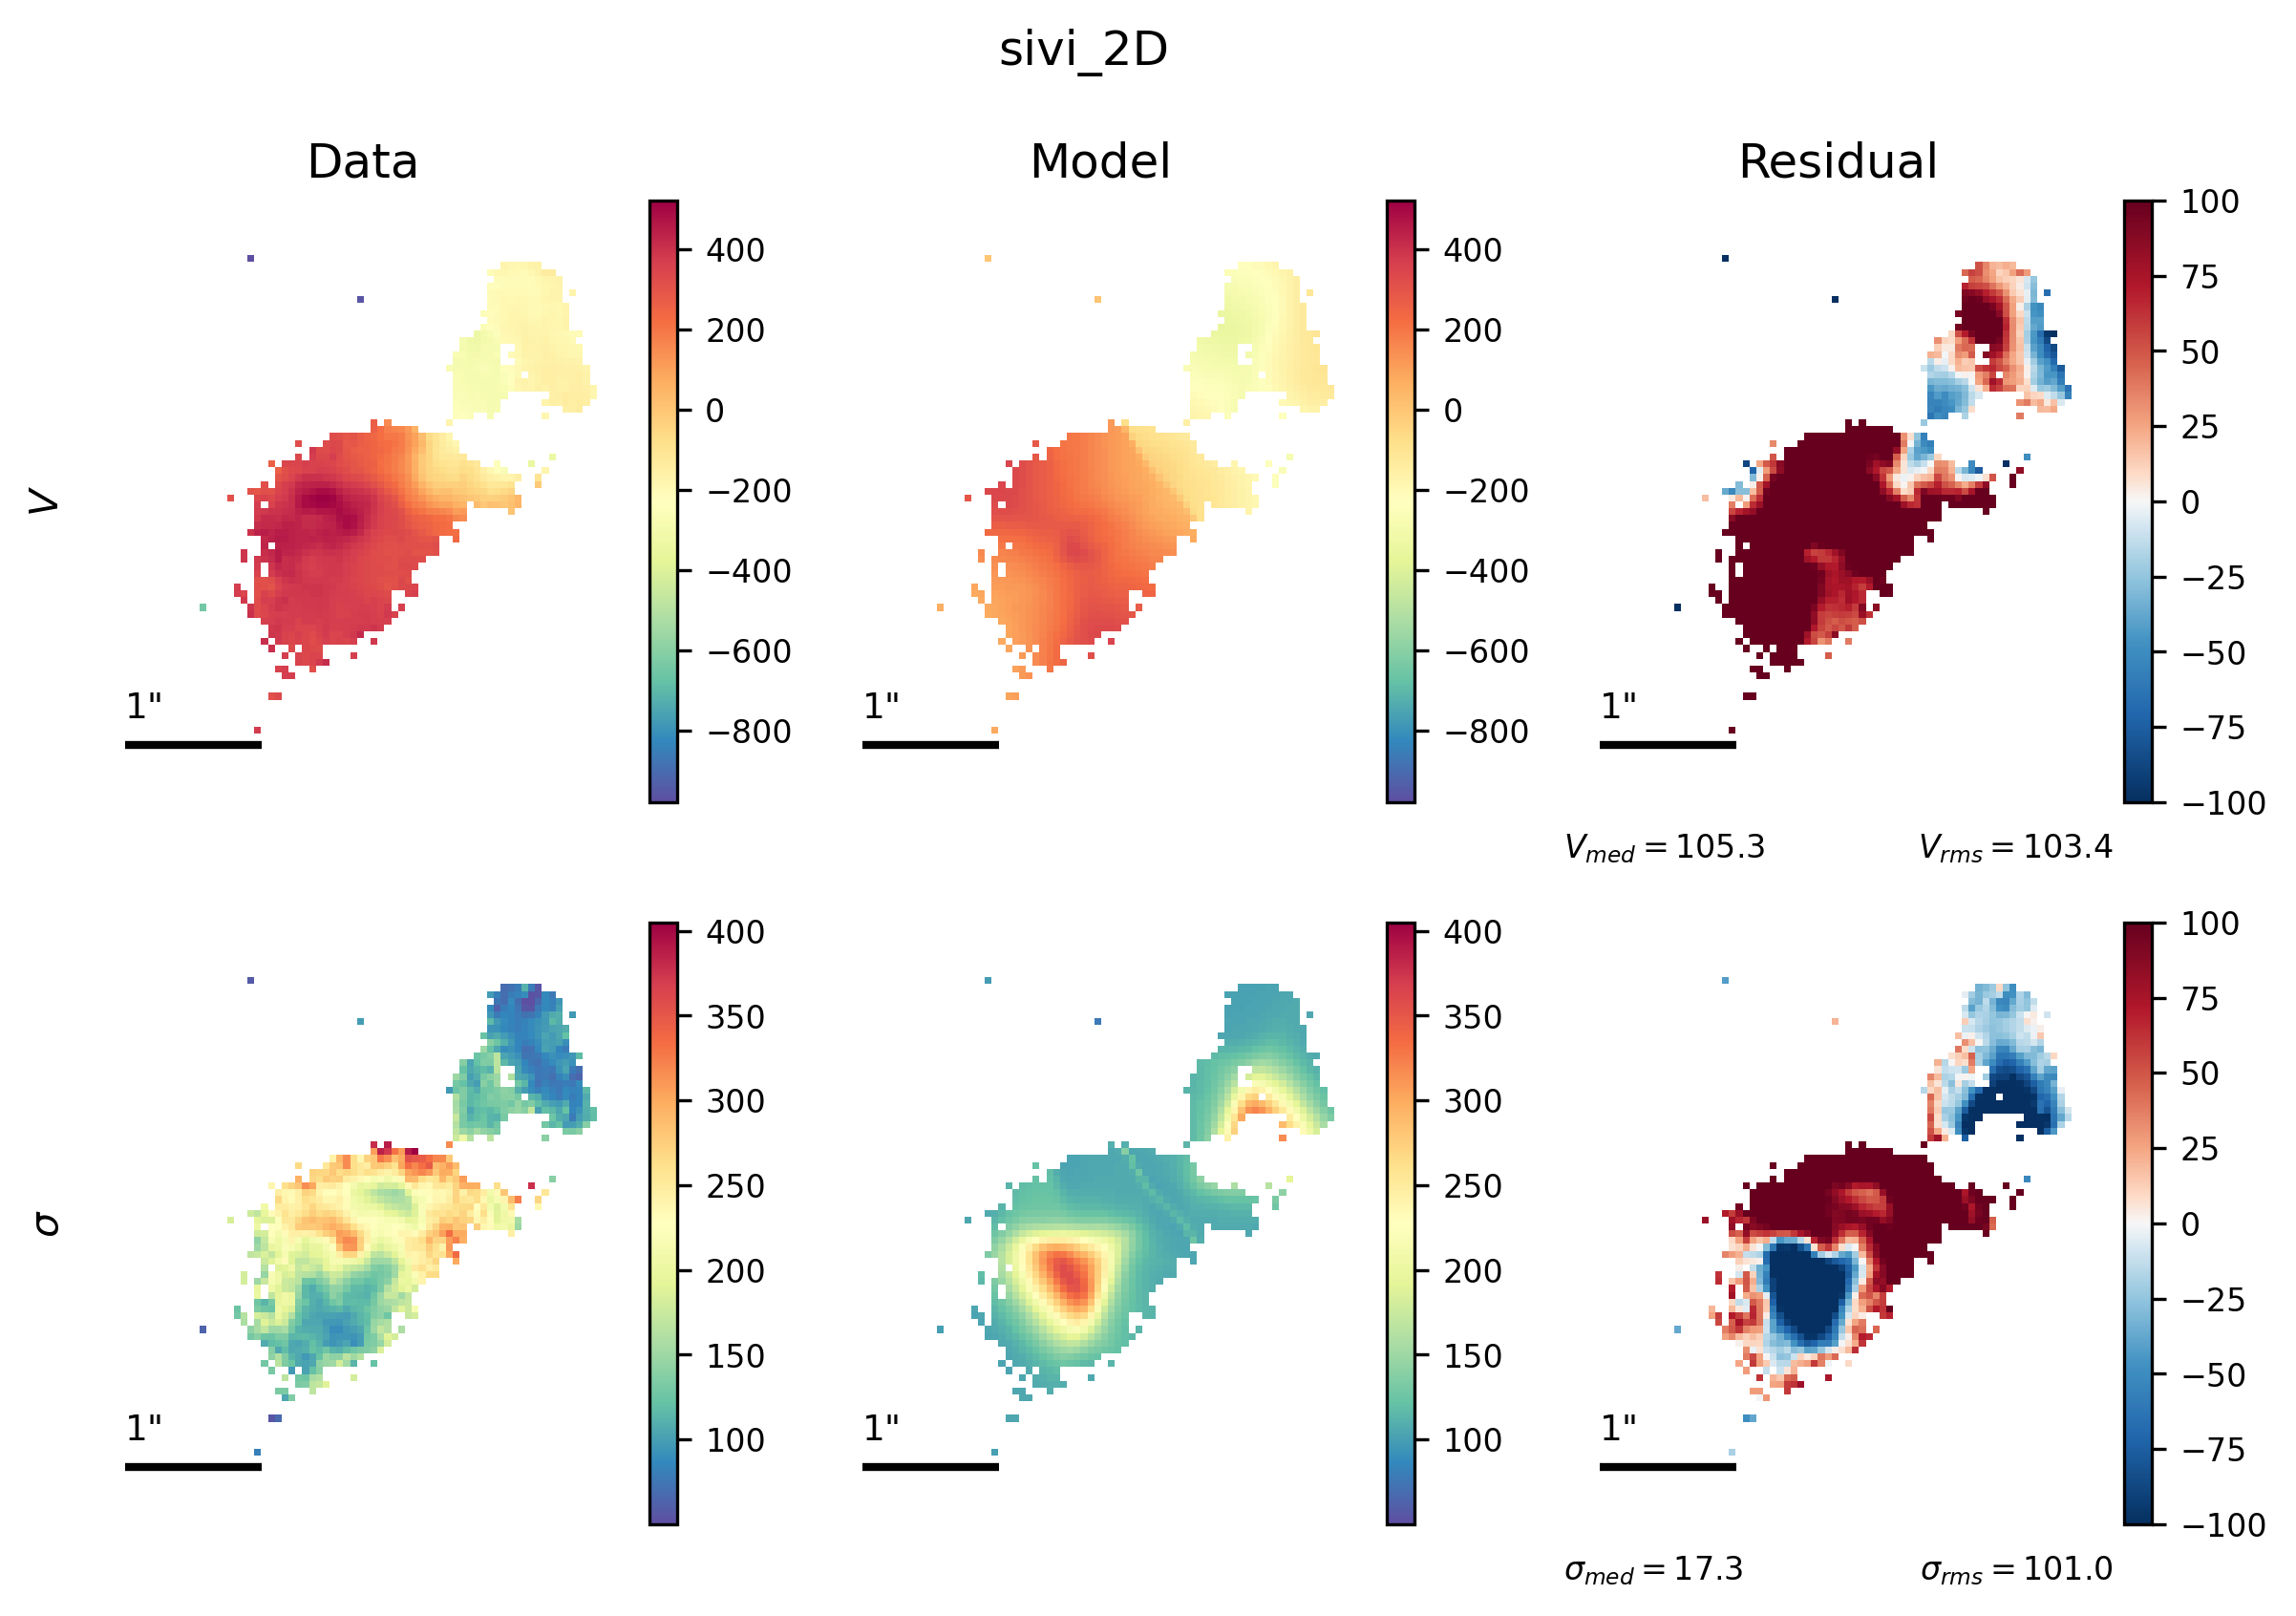

In [112]:
# Look at best-fit:
filepath = outdir_mcmc+"NGC5728_mcmc_bestfit_sivi_2D.{}".format(plot_type)
Image(filepath, width=600)

**Sampler "corner" plot**
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space. <p>
       *(&rarr; see the example in the :ref:`1D example fit <dysmalpy_example_fit_1D.ipynb>` tutorial)*
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

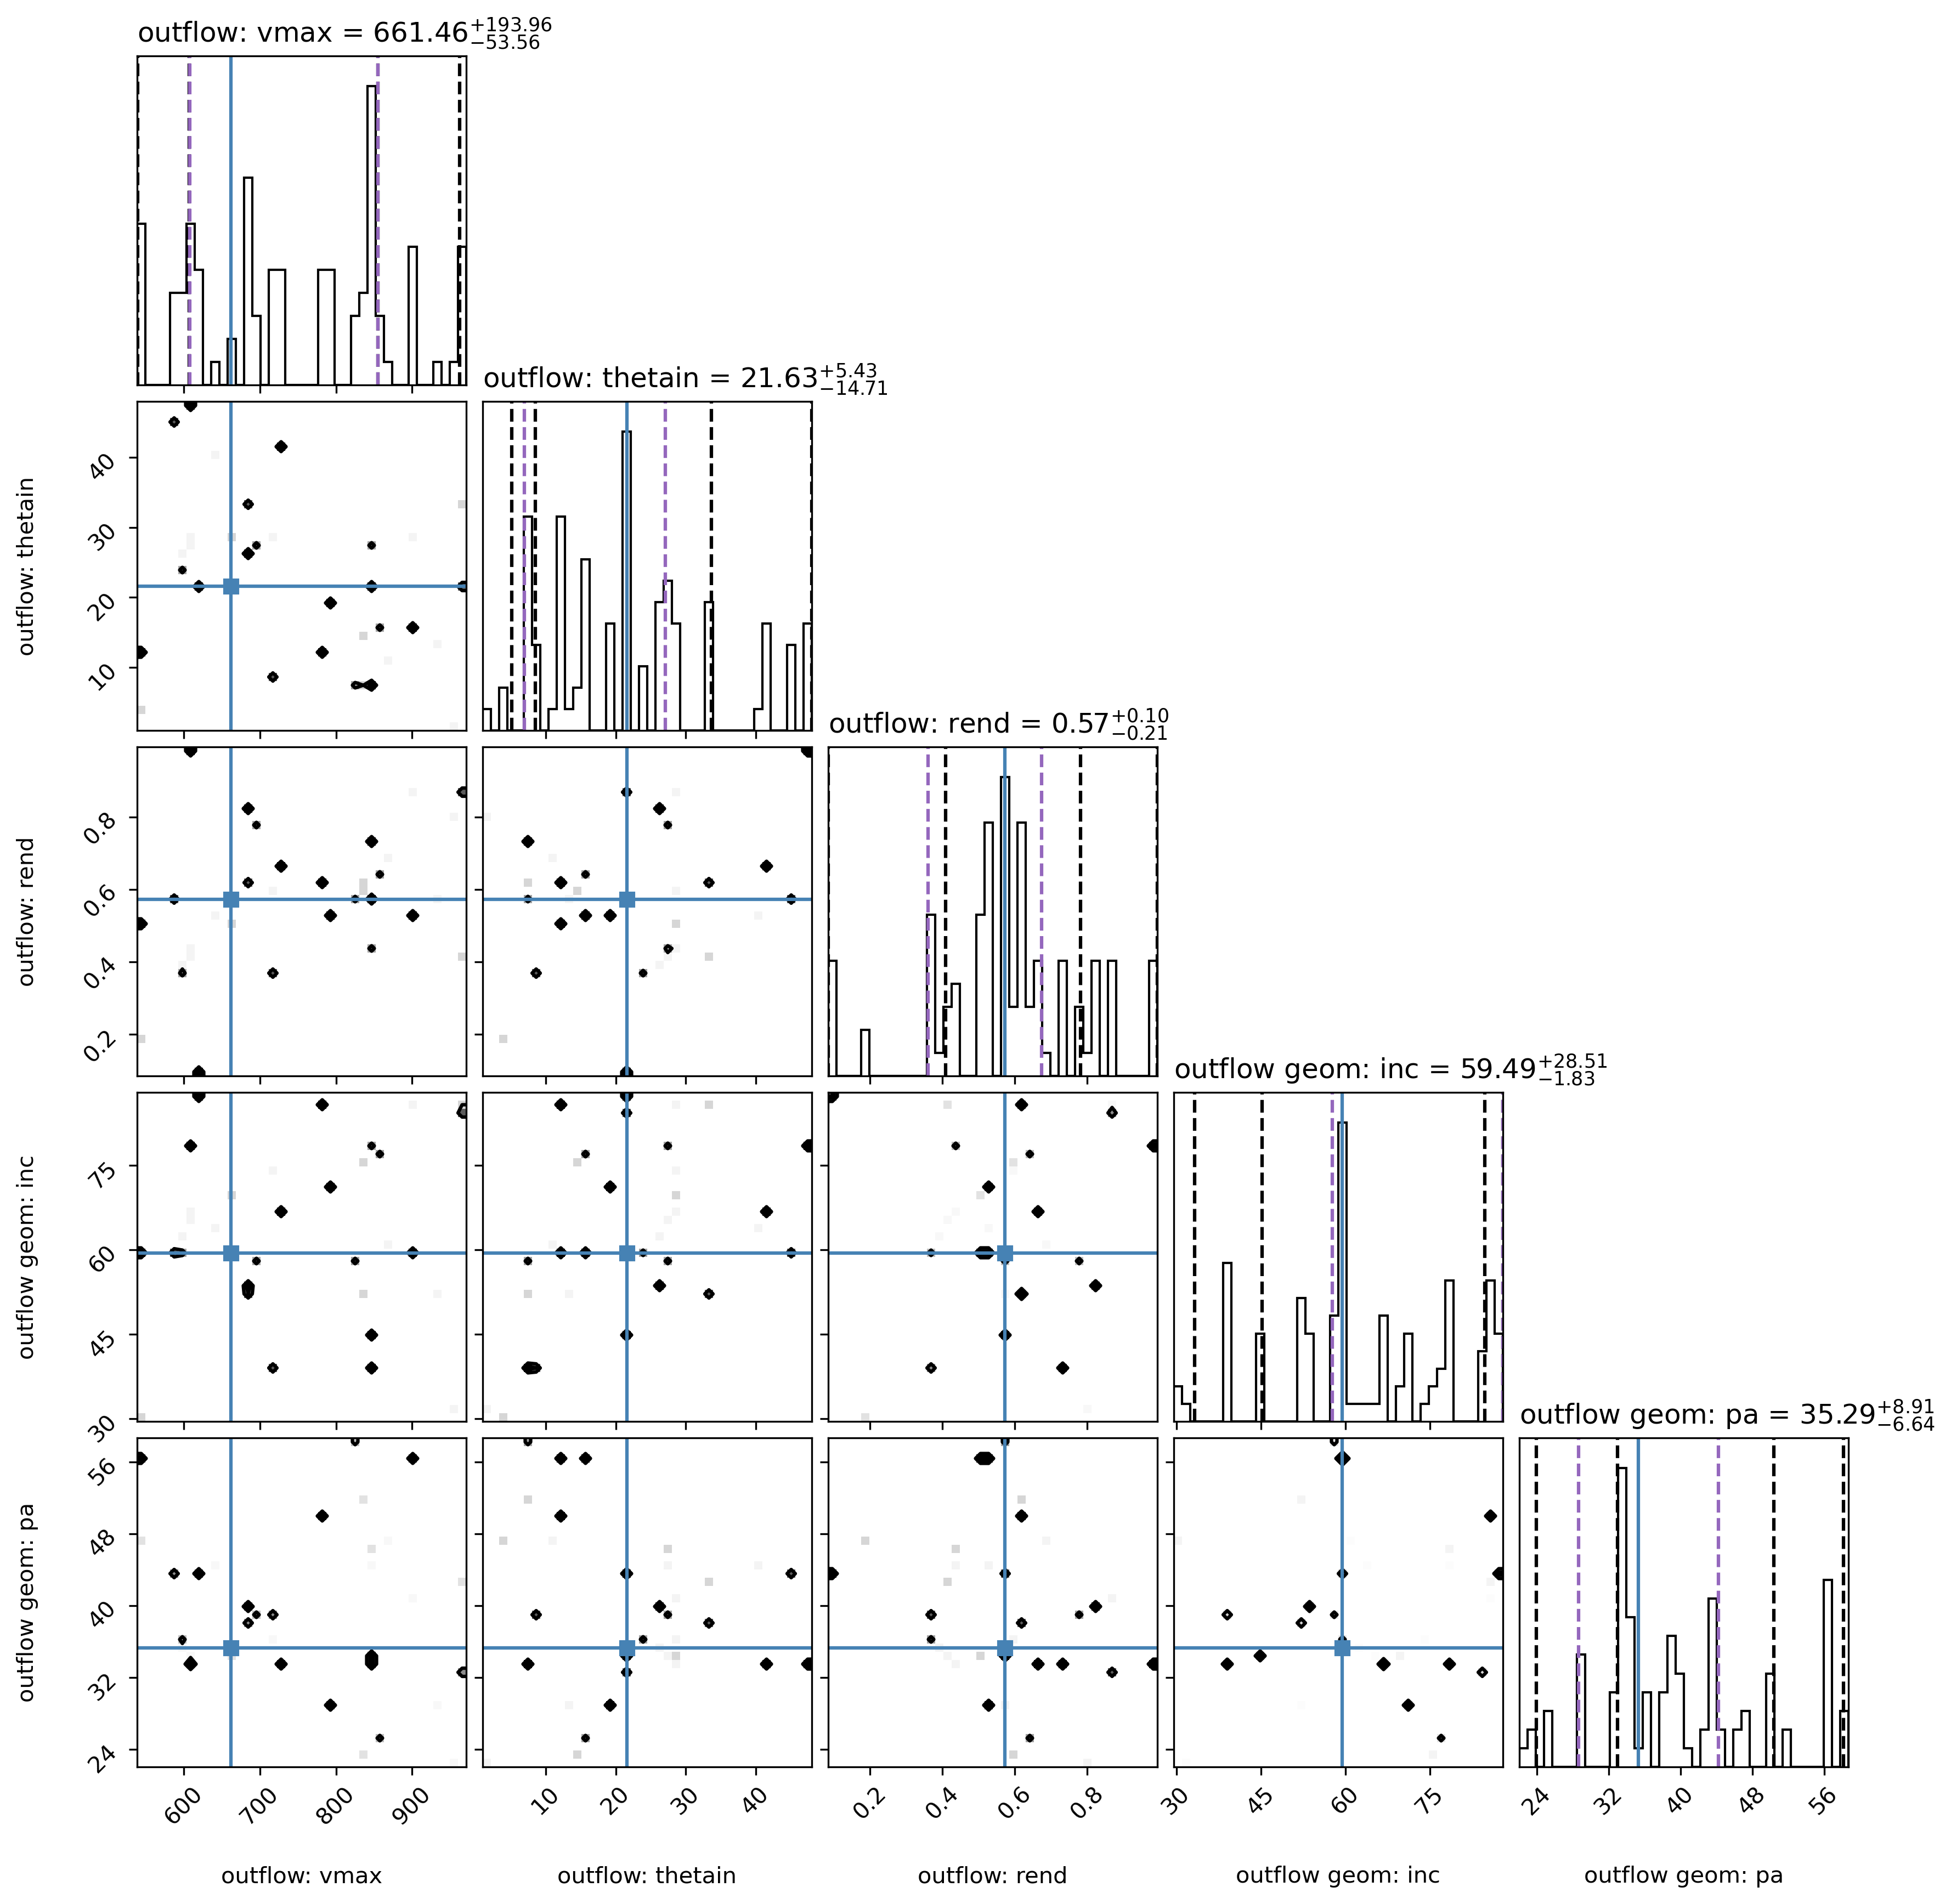

In [113]:
# Look at corner:
filepath = outdir_mcmc+"NGC5728_mcmc_param_corner.{}".format(plot_type)
Image(filepath, height=620)

---------

## A real MCMC example ##

In the interest of time, let's look at some results calculated previously.

For this fit, we used 1000 walkers, 175 burn-in steps, and 200 steps. 

Using **190 threads**, it took about **XX minutes** to run the MCMC fit. :warning:Check true run time!:warning:

In [114]:
outdir_mcmc_full = outdir_mcmc = outdir + 'MCMC_full_run_nw1000_ns200_a5/'

### Examine results: ###

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

**Reload the galaxy, results files:**

In [115]:
f_galmodel = outdir_mcmc_full + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'mcmc_results.pickle'

#----------------------------------------
## Fix module import
import sys
from dysmalpy import fitting_wrappers
sys.modules['fitting_wrappers'] = fitting_wrappers
#----------------------------------------


if os.path.isfile(f_galmodel) & os.path.isfile(f_mcmc_results):
    gal_full, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                                filename_results=f_mcmc_results, fit_method='mcmc')
else:
    gal_full = mcmc_results = None

**If necessary, also reload the sampler chain:**

In [116]:
f_sampler =  outdir_mcmc_full + 'mcmc_sampler.{}'.format(ftype_sampler)
if os.path.isfile(f_sampler) & (mcmc_results is not None):
    mcmc_results.reload_sampler_results(filename=f_sampler)

**Plot the best-fit results:**

In [117]:
if (gal_full is not None) & (mcmc_results is not None):
    mcmc_results.plot_results(gal_full)

#### Results report: ####

In [118]:
# Print report
if (gal_full is not None) & (mcmc_results is not None):
    print(mcmc_results.results_report(gal=gal_full))

**Or save results report to file:**

In [119]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
if (gal_full is not None) & (mcmc_results is not None):
    mcmc_results.results_report(gal=gal_full, filename=f_mcmc_report)